In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'ATOM'
yf_crypto = 'ATOM'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
#data = yf.Ticker('ADA-USD')
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Create dataframe with 5 most recent years
crypto_df = crypto_df.tail(1825)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2019-03-14,6.439715,6.639943,6.353963,6.526642,7318172
2019-03-15,6.633174,7.715249,6.432468,7.504351,6057301
2019-03-16,7.507990,8.305615,6.694531,7.383882,3477393
2019-03-17,7.357443,7.357443,4.727895,4.776164,2653565
2019-03-18,4.828242,5.229982,4.828242,5.110341,2567201


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-05,8.535205,8.728137,8.500226,8.692577,101131154
2024-06-06,8.692935,8.793395,8.573470,8.617699,111718832
2024-06-07,8.617626,8.690089,7.645950,8.098859,209205882
2024-06-08,8.098445,8.107482,7.726115,7.759524,131377792
2024-06-09,7.759129,7.938547,7.732251,7.881794,161954716


In [6]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
#crypto_df = pd.read_csv(
#    f'~/crypto-forecast/resources/{crypto}-USD.csv',
#    index_col='Date',
#    parse_dates=True
#).dropna()

# Sort by ascending date
#crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
#display(crypto_df.head())
#display(crypto_df.tail())

In [7]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

7.881793975830078

In [8]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.997146,0.995803,0.993418,0.693644
High,0.997146,1.000000,0.994629,0.997148,0.720800
Low,0.995803,0.994629,1.000000,0.996232,0.670261
Close,0.993418,0.997148,0.996232,1.000000,0.703710
Volume,0.693644,0.720800,0.670261,0.703710,1.000000


In [9]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [10]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2019-03-14,6.526642,7318172
2019-03-15,7.504351,6057301
2019-03-16,7.383882,3477393
2019-03-17,4.776164,2653565
2019-03-18,5.110341,2567201
...,...,...
2024-06-05,8.692577,101131154
2024-06-06,8.617699,111718832
2024-06-07,8.098859,209205882


In [11]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate volatility
df_close_ma.loc[:, 'Percent Change'] = df_close_ma['Close'].pct_change()*100
df_close_ma.loc[:, 'Volatility'] = df_close_ma['Percent Change'].rolling(10).std(ddof=0) * np.sqrt(252)

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [12]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,Percent Change,Volatility,SMA10,SMA30,SMA50
Date,,,,,,,
2019-05-02,4.594658,83803871,4.658959,202.684646,3.923099,4.221030,4.288250
2019-05-03,5.310845,161847461,15.587385,209.258983,4.041971,4.272493,4.263934
2019-05-04,5.259992,164883490,-0.957527,195.372930,4.204301,4.322917,4.219047
2019-05-05,4.853705,68292315,-7.724103,192.997424,4.359221,4.357759,4.168443
2019-05-06,4.725382,63030290,-2.643817,193.546765,4.468416,4.367026,4.167428


,Close,Volume,Percent Change,Volatility,SMA10,SMA30,SMA50
Date,,,,,,,
2024-06-05,8.692577,101131154,1.843873,27.495772,8.506406,8.559207,8.557066
2024-06-06,8.617699,111718832,-0.861410,22.610701,8.499258,8.548427,8.568591
2024-06-07,8.098859,209205882,-6.020631,36.004753,8.437227,8.515484,8.566461
2024-06-08,7.759524,131377792,-4.189911,39.672219,8.350546,8.470040,8.558403
2024-06-09,7.881794,161954716,1.575742,41.566864,8.284157,8.444531,8.542516


<Axes: xlabel='Date'>

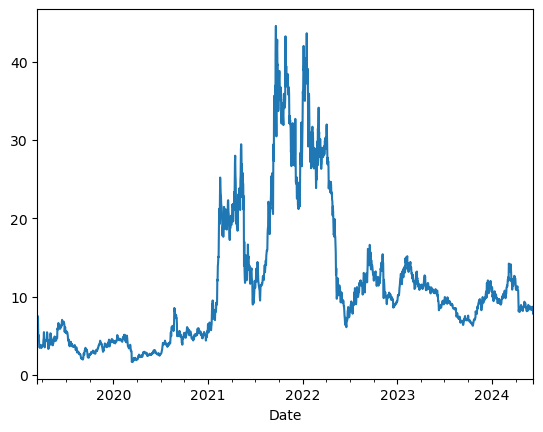

In [13]:
# Plot Close
df_close['Close'].plot()

In [14]:
## Create a Time Series Model with Prophet

In [15]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [16]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2019-03-14,6.526642,7318172
1,2019-03-15,7.504351,6057301
2,2019-03-16,7.383882,3477393
3,2019-03-17,4.776164,2653565
4,2019-03-18,5.110341,2567201
...,...,...,...
1910,2024-06-05,8.692577,101131154
1911,2024-06-06,8.617699,111718832
1912,2024-06-07,8.098859,209205882
1913,2024-06-08,7.759524,131377792


In [17]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [18]:
# Fit the time-series model.
crypto_model.fit(df_close)

11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:20 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
2000,2024-09-03
2001,2024-09-04
2002,2024-09-05
2003,2024-09-06
2004,2024-09-07


In [20]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2000,2024-09-03,7.563953,2.409125,11.239444,6.657389,8.598385,-0.862595,-0.862595,-0.862595,-0.041504,-0.041504,-0.041504,-0.821091,-0.821091,-0.821091,0.0,0.0,0.0,6.701358
2001,2024-09-04,7.558193,2.584306,10.713330,6.625364,8.617531,-0.727882,-0.727882,-0.727882,-0.048730,-0.048730,-0.048730,-0.679153,-0.679153,-0.679153,0.0,0.0,0.0,6.830310
2002,2024-09-05,7.552432,2.985424,11.218811,6.590937,8.627881,-0.543844,-0.543844,-0.543844,-0.019013,-0.019013,-0.019013,-0.524831,-0.524831,-0.524831,0.0,0.0,0.0,7.008588
2003,2024-09-06,7.546671,3.052025,11.660380,6.572426,8.660720,-0.327708,-0.327708,-0.327708,0.031543,0.031543,0.031543,-0.359251,-0.359251,-0.359251,0.0,0.0,0.0,7.218964
2004,2024-09-07,7.540911,2.621919,11.620289,6.510350,8.674439,-0.142617,-0.142617,-0.142617,0.041297,0.041297,0.041297,-0.183914,-0.183914,-0.183914,0.0,0.0,0.0,7.398294


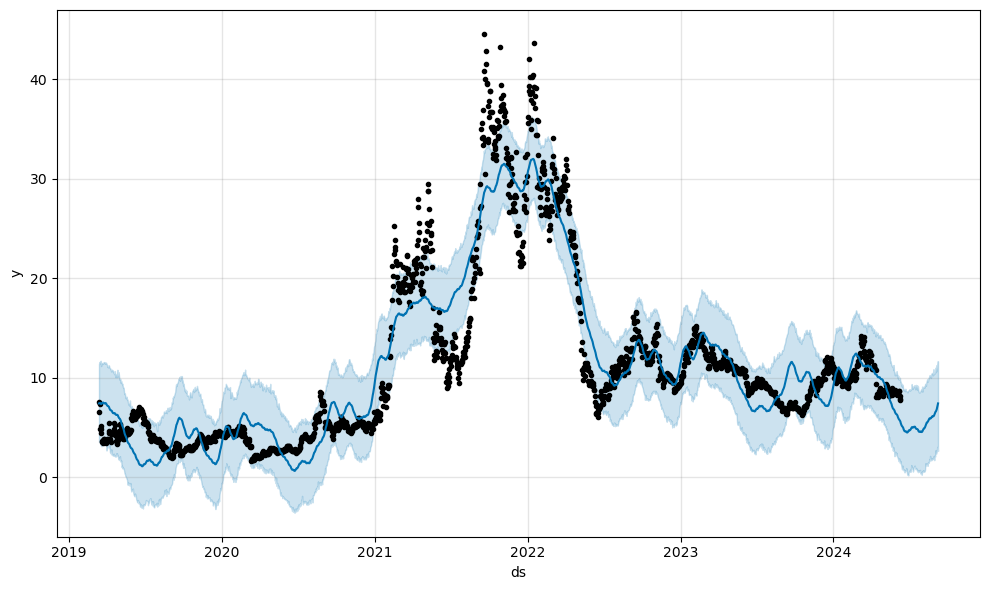

In [21]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [22]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [23]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-10,5.405957,1.386617,9.573037
2024-06-11,5.283740,1.201652,9.209591
2024-06-12,5.178407,0.931662,9.385602
2024-06-13,5.111722,0.761427,9.075859
2024-06-14,5.068847,1.143414,9.297994
...,...,...,...
2024-09-03,6.701358,2.409125,11.239444
2024-09-04,6.830310,2.584306,10.713330
2024-09-05,7.008588,2.985424,11.218811


In [24]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

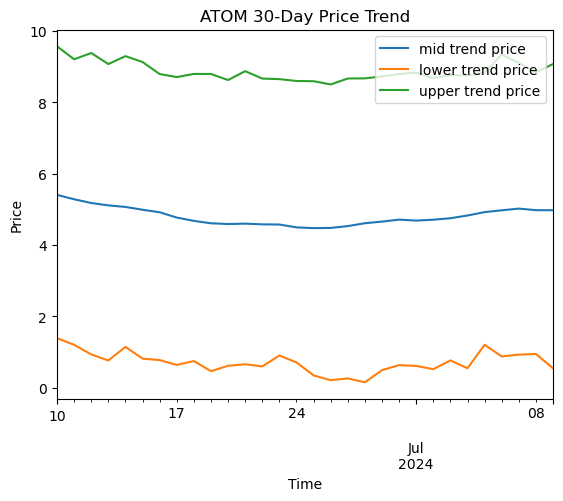

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

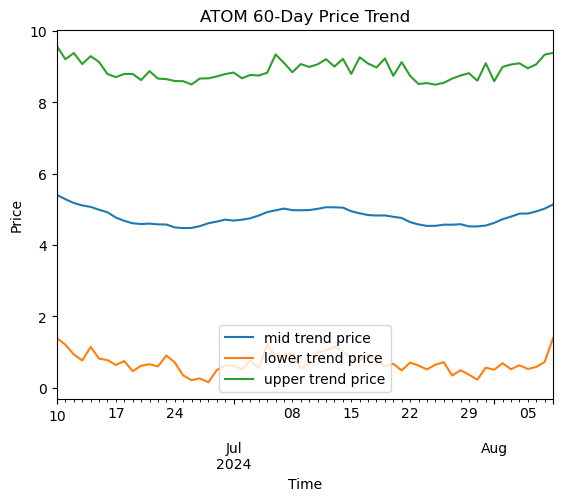

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

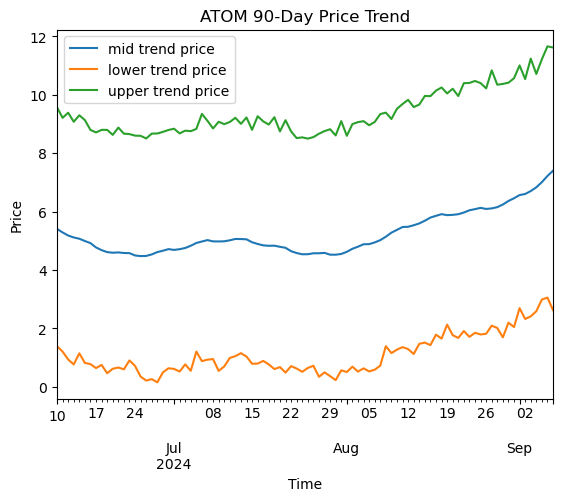

In [27]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend') 
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
#plt.savefig(f'/forecasts/{date}/{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [28]:
# Retrieve last closing price
last_close_price

7.881793975830078

In [29]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

5.405956907547767

In [30]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

6.643875441688923

In [31]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

5.435505038240411

In [32]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

4.925669792805206

In [33]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

5.229901983280179

In [34]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

7.287418186600547

In [35]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.259

In [36]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.213

In [37]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.097

In [38]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

In [39]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
#fig_comp = crypto_model.plot_components(crypto_forecast)
#plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

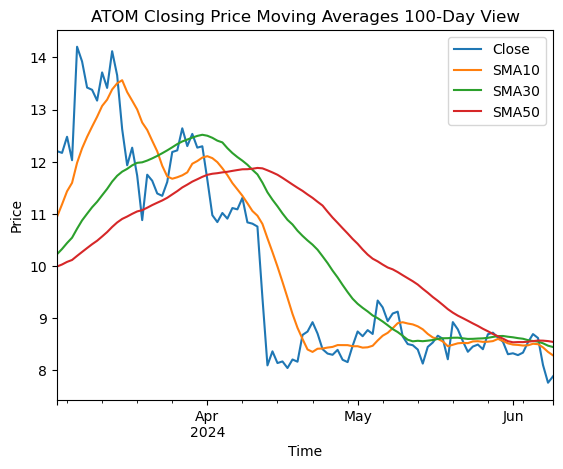

In [40]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

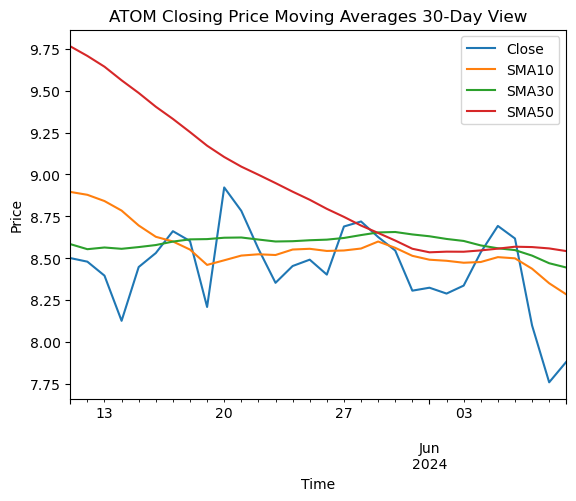

In [41]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [42]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-10
File created :  2024-06-10.csv


In [43]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [44]:
f = open(f'{file_name}', "r")
print(f.read())

ATOM,7.881793975830078,-0.25861497012757617,-0.212823595327564,0.09686255417636636

